In [1]:
import numpy as np
import seaborn as sns
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import distance_matrix
from skimage import io
from tqdm import tqdm as progress_bar

In [9]:
M=64
N=3

In [2]:
def propeller(theta, m):
    """Simulate a properller using simple function"""
    return np.sin(N*theta + m * np.pi / 10)

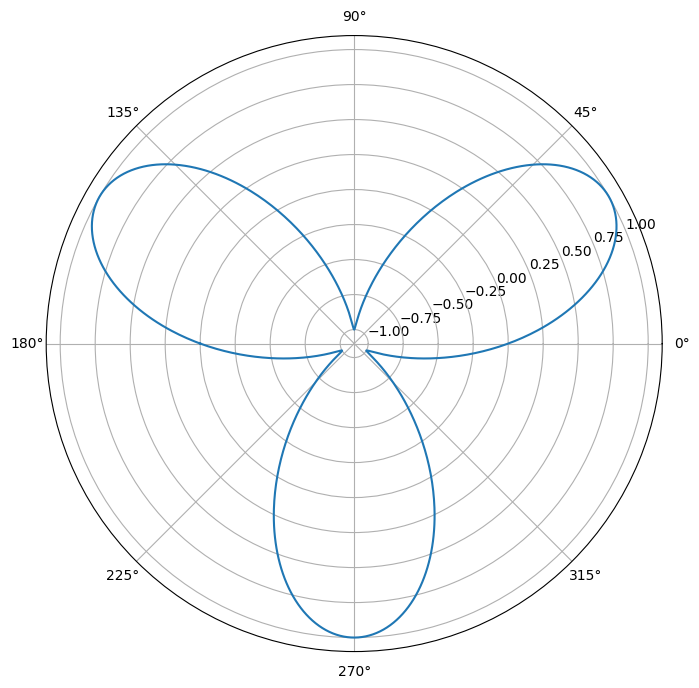

In [10]:
thetas = np.linspace(-np.pi, np.pi, 1000)
r = propeller(thetas, m=0)

_ = plt.figure(figsize=[8, 8])
_ = plt.polar(thetas, r)

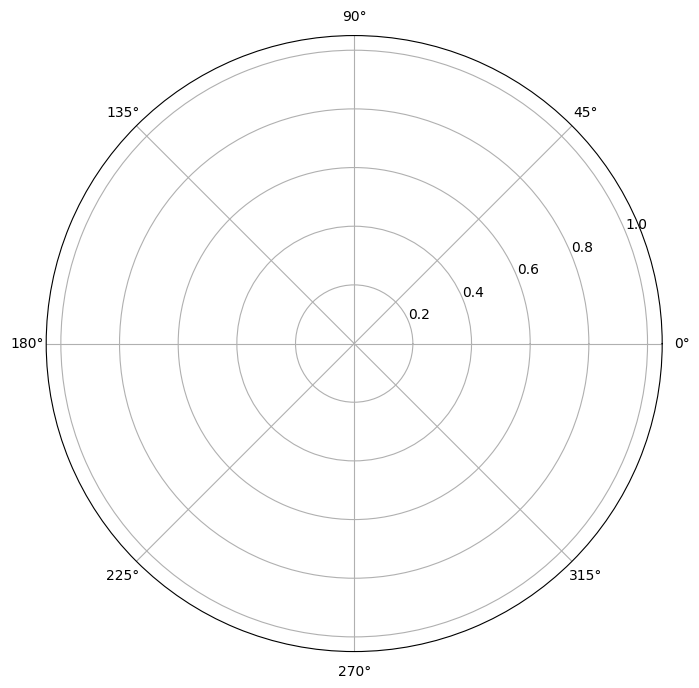

In [4]:
figure = plt.figure(figsize=[8, 8])
plot = plt.polar([])[0]

In [5]:
def animate(frame):
    propeller_curve = propeller(thetas, m=frame)
    plot.set_data((thetas, propeller_curve))

In [6]:
animation = FuncAnimation(figure, animate, frames=100, interval=25)

In [24]:
#video = animation.to_html5_video()
#html = display.HTML(video)
#display.display(html)

#plt.close()

In [11]:
thetas = np.linspace(-np.pi, np.pi, 1000)
rs = propeller(thetas, m=0)

In [12]:
def polar_to_cartesian(theta, r):
    """Convert polar coordinate arrays to cartesian"""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack([x, y])


def capture(func: np.array, resolution: int, threshold: float = 0.1, low: float = -1, high: float = 1) -> np.array:
    """
    Simulation of image capture by CMOS sensor of any mathematical function represented as array of 2D points

    :param func: array containing data-points of some mathematical curve of 2D pattern
    :param resolution: number of pixels of square grid
    :param threshold: distance threshold for image capture
    :param low: lower border of the sensor grid
    :param high: upper border of the sensor grid
    """
    grid_x, grid_y = np.meshgrid(np.linspace(low, high, resolution), np.linspace(low, high, resolution))
    grid = np.column_stack([grid_x.flatten(), grid_y.flatten()])

    distances = distance_matrix(grid, func)
    capture = (np.min(distances, axis=1) <= threshold).astype(int).reshape(resolution, resolution)
    
    return capture

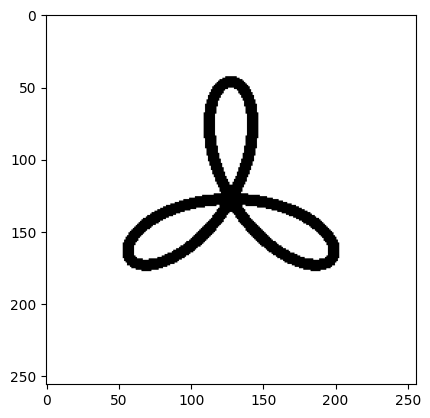

In [13]:
_ = plt.imshow(capture(polar_to_cartesian(thetas, rs), resolution=256, threshold=0.05, low=-np.pi / 2, high=np.pi / 2), cmap="Greys")

na sprawozdaniu tylko przeanalizowanie prędkości, pikselów, tego efektu sensorycznego

In [16]:
thetas = np.linspace(-np.pi, np.pi, 1000)  # linspace of angles to plot
ms = np.arange(-M // 2, M // 2)

In [17]:
funcs = []

for m in ms.tolist():
    r = propeller(thetas, m=m)
    func = polar_to_cartesian(thetas, r)
    funcs.append(func)

funcs = np.asarray(funcs)

In [18]:
def record(funcs: list, capture_kwargs) -> np.array:
    """Simulate recording by applying capture in loop"""
    return np.asarray([capture(func, **capture_kwargs) for func in progress_bar(funcs)])

In [20]:
recording = record(funcs, capture_kwargs=dict(resolution=256, threshold=0.05, low=-np.pi / 2, high=np.pi / 2))
recording.shape

100%|██████████| 64/64 [05:22<00:00,  5.03s/it]


(64, 256, 256)

In [21]:
offset = 0
length = 4
capture = np.zeros([256, 256])

for frame in recording:
    capture[offset : offset + length, :] = frame[offset : offset + length, :]
    offset += length

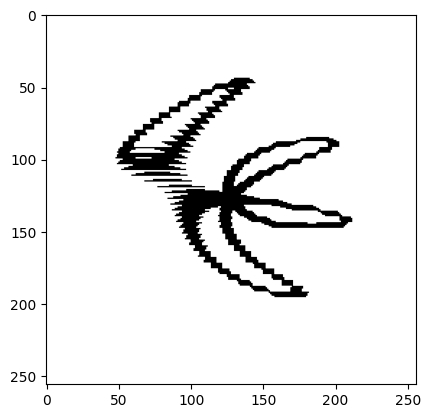

In [26]:
plt.imshow(capture, cmap="Greys")